In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
from matplotlib import lines

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

## Graph parameters
plt.rc_context({'axes.edgecolor': 'grey', 'xtick.color': 'grey',
                    'ytick.color': 'grey'})

In [2]:
## Boston Marathon data for 2014
## Note the conversion of dashes to NaN

bm2014 = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv',
                    na_values='-')

# Boston Marathon Data Project

## Intro to the data

In [3]:
print(bm2014.shape)
bm2014.head()

(31984, 21)


,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


The dataset contains information on over 30,000 participants in the Boston Marathon 2014. There are 21 features, of which around half are participant timings at different distances e.g. 5k, 10k etc.

#### Important things to note

- There are wheelchair racers within the data who can be distinguished with the W in the 'bib' variable.
- Wheelchair racers on average are faster than runners.
- The 'overall' variable denotes the place that the participant came in the race. There are two of each number up to 52 because the wheelchair racers are counted separately.
- I have no idea what 'ctz' is.

Summaries of each variable are shown below.

In [4]:
bm2014.describe()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,31934.000000,31984.000000,31768.000000,31984.000000,31984.000000,31984.000000,31950.000000,31984.000000,31984.000000,31944.000000,31932.000000,31912.000000,31933.000000,31945.000000
mean,51.799275,1932.563032,133.612055,42.407079,242.997314,8051.044741,196.857605,15939.587825,9.275658,164.571219,25.755559,111.664566,105.711669,229.001490
std,8.965513,1715.228694,25.596958,11.316496,52.300431,4754.005626,41.979107,9232.978224,1.992486,33.953683,4.327830,21.061188,19.780525,49.159902
min,16.620000,1.000000,45.800000,18.000000,80.600000,1.000000,67.420000,1.000000,3.080000,56.450000,7.750000,38.030000,36.100000,76.100000
25%,45.400000,610.000000,115.470000,33.000000,205.527500,3972.000000,167.122500,7943.750000,7.850000,140.670000,22.650000,96.845000,91.750000,193.820000
50%,50.330000,1425.000000,128.875000,42.000000,232.370000,7970.000000,188.170000,15939.500000,8.870000,157.730000,25.080000,107.830000,102.150000,218.850000
75%,57.170000,2611.000000,147.735000,50.000000,273.235000,11968.000000,220.170000,23935.250000,10.430000,182.880000,28.470000,123.070000,116.520000,257.450000
max,112.380000,6979.000000,289.020000,81.000000,538.880000,17575.000000,449.330000,31931.000000,20.570000,376.380000,86.950000,236.670000,224.350000,508.350000


In [5]:
bm2014.describe(include='object')

,name,gender,bib,ctz,state,country,city
count,31984,31984,31984,1244,29408,31984,31983
unique,31915,2,31984,84,68,78,5934
top,"Benson, Craig",M,11612,GBR,MA,USA,Boston
freq,2,17617,1,171,7587,27233,1034


Interesting that Thomas Whalen managed to participate twice.

Let's do some clustering.

## Clustering to find wheelchair racers

Firstly I am going to use clustering to see if it is possible to identify the wheelchair racers from the runners using clustering.

In [6]:
## Remove all the variables which are categorical or unhelpful (e.g. overall)

bm2014_times = bm2014.copy()
bm2014_times.drop(['name', 'division', 'gender', 'age', 'bib', 'genderdiv', 
                   'overall', 'ctz', 'state', 'country', 'city'], axis=1, inplace=True)
bm2014_times.dropna(inplace=True)

## Create and binarize outcome variable

bm2014_bib = bm2014.loc[bm2014.index.isin(bm2014_times.index), ['bib']]
bib = np.where(bm2014_bib['bib'].str.contains('W'), 1, 0)

In [7]:
## Normalize by feature, not by sample
## If don't do this it suppresses the time differences between people

times_norm = normalize(bm2014_times, axis=0)

In [8]:
## Repeat for just two variables - halfway and overall times

half_official = pd.DataFrame({
    'half': bm2014_times['half'],
    'official': bm2014_times['official']
})

half_off_norm = normalize(half_official, axis=0)

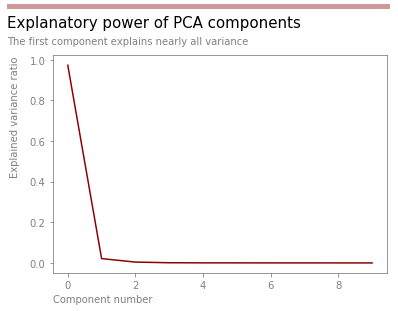

In [9]:
## Create PCA components

pca_t = PCA(n_components=10)
times_pca = pca_t.fit_transform(times_norm)

with plt.rc_context({'axes.edgecolor': 'grey', 'xtick.color': 'grey',
                    'ytick.color': 'grey'}):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(pca_t.explained_variance_ratio_, color='darkred')
    fig.suptitle('Explanatory power of PCA components', 
                 ha='left', x=0.02, y=1.02,
                fontsize=15)
    ax.set_title('The first component explains nearly all variance',
                 ha='left', x=0.02, y=0.92, transform=fig.transFigure,
             fontsize=10, color='grey')
    ax.set_xlabel('Component number', horizontalalignment='left', x=0, color='grey')
    ax.set_ylabel('Explained variance ratio', horizontalalignment='right', y=1, rotation=90, labelpad=10, color='grey')
    line = lines.Line2D([0.025, 0.9], [1.05, 1.05], transform=fig.transFigure, lw=5., color='darkred', alpha=0.4)
    line.set_clip_on(False)
    ax.add_line(line)
    plt.show()

In [10]:
## This shows only the first component is really useful
## Keep two as useful for plotting

pca_t = PCA(n_components=2)
times_pca = pca_t.fit_transform(times_norm)

#### Actual clustering of wheelchair racers

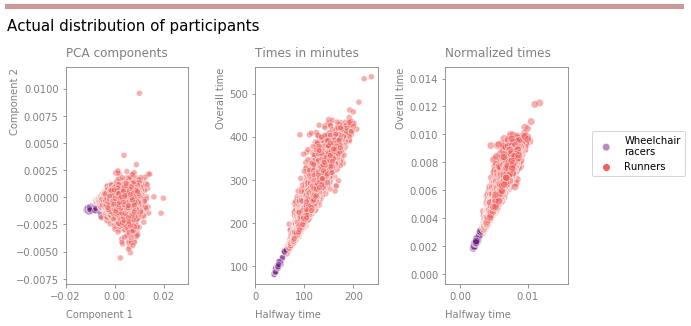

In [11]:
## Plot actual wheelchair racers

fig = plt.figure(figsize=(9, 4))
plt.subplots_adjust(wspace=0.55)

ax1 = fig.add_subplot(1, 3, 1)
sns.scatterplot(times_pca[:, 0], times_pca[:, 1], hue=bib, alpha=.5, legend=False, palette='magma_r')
ax1.set_title('PCA components', ha='left', x=0, y=1.02, color='gray')
plt.xlim([-0.02, 0.03])
plt.xlabel('Component 1', ha='left', x=0, color='grey', labelpad=7.5)
plt.ylabel('Component 2', ha='right', y=1, color='grey', labelpad=-5)

ax2 = fig.add_subplot(1, 3, 2)
sns.scatterplot(bm2014_times['half'], bm2014_times['official'], hue=bib, alpha=.5, legend=False, palette='magma_r')
#plt.title('Times in minutes', position=(0.09, 1.05), color='gray')
ax2.set_title('Times in minutes', ha='left', x=0, y=1.02, color='gray')
ax2.set_xlim([0, 250])
ax2.set_xlabel('Halfway time', ha='left', x=0, color='grey', labelpad=7.5)
ax2.set_ylabel('Overall time', ha='right', y=1, color='grey')

ax3 = fig.add_subplot(1, 3, 3)
sns.scatterplot(half_off_norm[:, 0], half_off_norm[:, 1], hue=bib, alpha=.5, s=55, palette='magma_r')
ax3.set_title('Normalized times', ha='left', x=0, y=1.02, color='gray')
plt.xlabel('Halfway time', ha='left', x=0, color='grey', labelpad=7.5)
plt.ylabel('Overall time', ha='right', y=1, color='grey')
plt.locator_params(axis='x', nbins=2)
plt.legend(['Wheelchair\nracers', 'Runners'], loc=(1.2, 0.5))

#plt.tight_layout()
plt.suptitle('Actual distribution of participants', ha='left', x=0.035, y=1.05, fontsize=15)
line = lines.Line2D([0.035, 1.075], [1.09, 1.09], transform=fig.transFigure, lw=5, color='darkred', alpha=.4)
line.set_clip_on(False)
ax1.add_line(line)
plt.show()

#### KMeans

Firstly, I tested KMeans clustering techniques using different numbers of clusters. The results are printed below.

In [12]:
results = pd.DataFrame()
results['actual'] = bib

for n_clust in range(2, 15):
    bib_model = KMeans(n_clusters=n_clust, random_state=55).fit(times_norm)
    bib_pred = bib_model.predict(times_norm)
    results['cluster_' + str(n_clust)] = bib_pred
    print(pd.crosstab(results['cluster_{}'.format(n_clust)], results['actual']), '\n')

actual         0   1
cluster_2           
0          21254  53
1          10342   0 

actual         0   1
cluster_3           
0          13750  53
1           5737   0
2          12109   0 

actual         0   1
cluster_4           
0           8779  53
1           3348   0
2          12062   0
3           7407   0 

actual         0   1
cluster_5           
0           6456  53
1           5088   0
2           2481   0
3           7544   0
4          10027   0 

actual        0   1
cluster_6          
0          7258   0
1          3559   0
2          5388  53
3          8574   0
4          5143   0
5          1674   0 

actual        0   1
cluster_7          
0          4099   0
1          6455   0
2          1343   0
3          2814   0
4          5698   0
5          3800  53
6          7387   0 

actual        0   1
cluster_8          
0           933   0
1          5790   0
2          7100   0
3          2171   0
4          2040  53
5          4480   0
6          5550   0
7     

Clusters 12 and 14 worked best, correctly categorizing 47/53 wheelchair racers into a single category. Combining the other categories into one gives the following overall results.

actual           0   1
cluster_14a           
0            31596   6
1                0  47
ARI: 0.939726645952568 



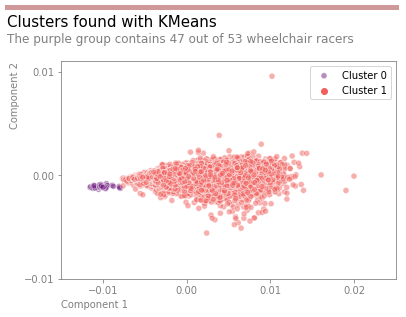

In [22]:
results['cluster_14a'] = np.where(results['cluster_14'] == 13, 1, 0)

print(pd.crosstab(results['cluster_14a'], results['actual']))
print('ARI:', adjusted_rand_score(results['cluster_14a'], results['actual']), '\n')

fig = plt.figure()
ax = fig.add_subplot(111)
g = sns.scatterplot(times_pca[:, 0], times_pca[:, 1], 
                    hue=results['cluster_14a'].values, alpha=.5, 
                    palette='magma_r')
ax.set_xlim([-0.015, 0.025])
ax.set_ylim([-0.01, 0.011])
ax.locator_params(axis='y', nbins=3)
ax.locator_params(axis='x', nbins=4)
fig.suptitle('The purple group contains 47 out of 53 wheelchair racers',
             ha='left', x=0, color='gray')
ax.set_title('Clusters found with KMeans',
            transform=fig.transFigure, ha='left', x=0, fontsize=15)
ax.set_xlabel('Component 1', color='gray', ha='left', x=0)
ax.set_ylabel('Component 2', color='gray', ha='right', y=1)
g.legend(['Cluster 0', 'Cluster 1'])
line = lines.Line2D([0, 0.9], [1.07, 1.07], lw=5, color='darkred', alpha=.4, transform=fig.transFigure)
line.set_clip_on(False)
ax.add_line(line)
plt.show() 

This is a reasonably accurate cluster. However, it could well be overfitting and there is no guarantee that the same cluster number would be applicable in new data.

#### Mini Batch KMeans

Next, I tested whether MiniBatchKMeans could perform similarly, or better, to KMeans.

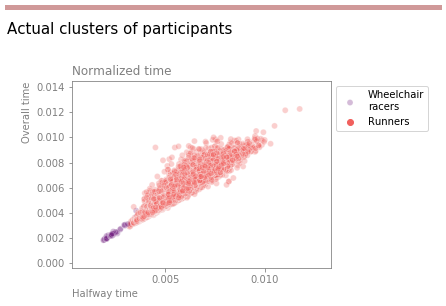

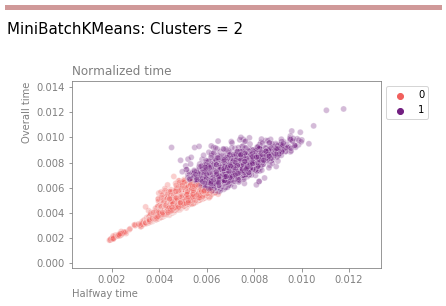

actual            0   1
mbkm_clust_2           
0             22279  53
1              9317   0 



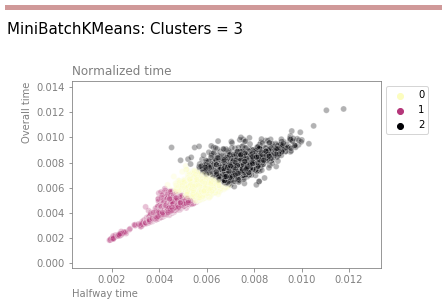

actual            0   1
mbkm_clust_3           
0             12005   0
1             14149  53
2              5442   0 



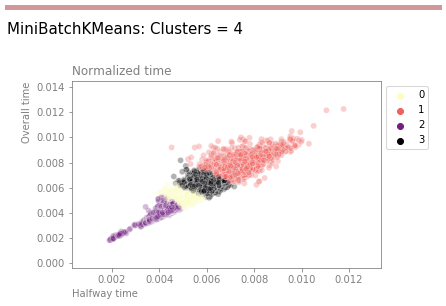

actual            0   1
mbkm_clust_4           
0             11056   0
1              4741   0
2              7649  53
3              8150   0 



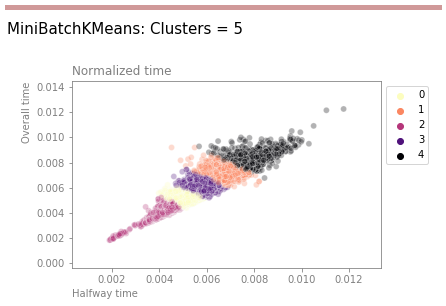

actual            0   1
mbkm_clust_5           
0             10665   0
1              4387   0
2              7531  53
3              7226   0
4              1787   0 



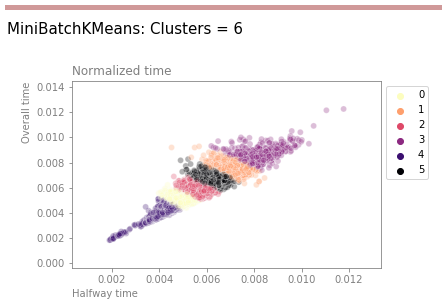

actual            0   1
mbkm_clust_6           
0             10015   0
1              2742   0
2              6963   0
3              1100   0
4              6469  53
5              4307   0 



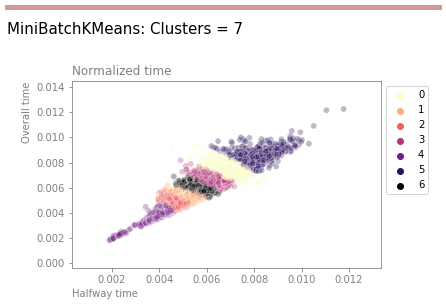

actual           0   1
mbkm_clust_7          
0             2839   0
1             7111   0
2             7023   0
3             3773   0
4             4547  53
5             1388   0
6             4915   0 



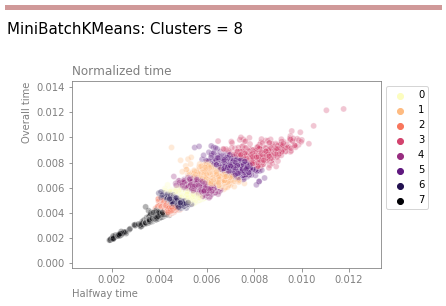

actual           0   1
mbkm_clust_8          
0             6600   0
1             4129   0
2             4388   1
3              981   0
4             5838   0
5             2276   0
6             5658   0
7             1726  52 



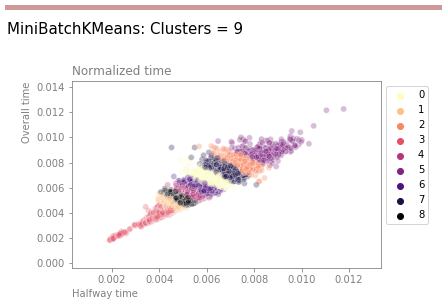

actual           0   1
mbkm_clust_9          
0             3228   0
1             5050   0
2             1399   0
3             3978  53
4             5088   0
5              673   0
6             4094   0
7             2296   0
8             5790   0 



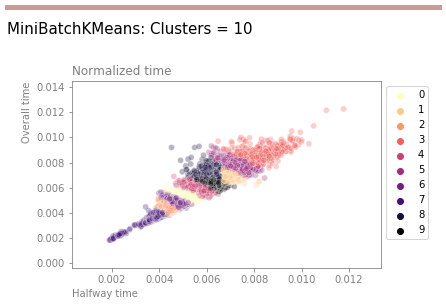

actual            0   1
mbkm_clust_10          
0              6332   0
1              1875   0
2              4468   1
3               916   0
4              4968   0
5              1699   0
6              5603   0
7              1648  52
8               926   0
9              3161   0 



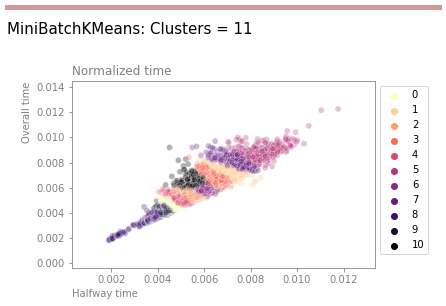

actual            0   1
mbkm_clust_11          
0              4221   0
1              1819   0
2              5273   0
3              3135   0
4              5608   0
5               799   0
6              3635   0
7              1175   0
8              1297  52
9              3507   1
10             1127   0 



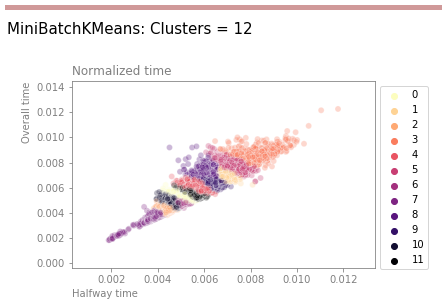

actual            0   1
mbkm_clust_12          
0              4236   0
1              1821   0
2              3918   1
3               919   0
4              3289   0
5              1663   0
6              3291   0
7              1522  52
8               872   0
9              2754   0
10             3426   0
11             3885   0 



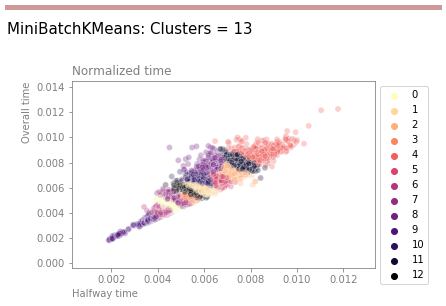

actual            0   1
mbkm_clust_13          
0              4261   0
1              3277   0
2              1717   0
3              3765   0
4               667   0
5              2325   0
6              3453   3
7              4688   0
8               448   0
9               545  50
10             1718   0
11             1184   0
12             3548   0 



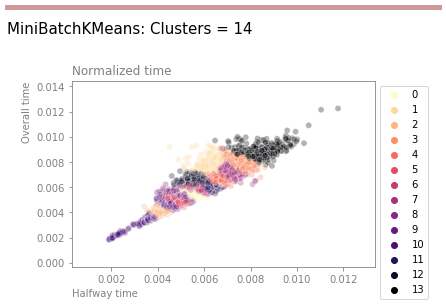

actual            0   1
mbkm_clust_14          
0              3605   0
1               406   0
2              3238   3
3              1223   0
4              2360   0
5              4334   0
6              2852   0
7              1776   0
8              4165   0
9              3617   0
10              477  50
11             2054   0
12              808   0
13              681   0 



In [14]:
results2 = pd.DataFrame()
results2['actual'] = bib

fig = plt.figure()
ax2 = fig.add_subplot(1, 1, 1)
g2 = sns.scatterplot(half_off_norm[:, 0], half_off_norm[:, 1], 
                     hue=bib, alpha=.3, palette='magma_r')
ax2.set_xlabel('Halfway time', color='gray', ha='left', x=0)
ax2.set_ylabel('Overall time', color='gray', ha='right', y=1)
ax2.set_title('Normalized time', color='gray', ha='left', x=0)
ax2.locator_params(axis='x', nbins=3)
plt.suptitle('Actual clusters of participants', ha='left', 
             fontsize=15, x=0, y=1)
plt.legend(['Wheelchair\nracers', 'Runners'], loc='upper left', bbox_to_anchor=[1, 1])
line = lines.Line2D([0, 1], [1.05, 1.05], lw=5, color='darkred', alpha=.4,
                   transform=fig.transFigure)
line.set_clip_on(False)
ax2.add_line(line)
plt.tight_layout()
plt.show()

for n_clust in np.arange(2, 15):
    bib_model = MiniBatchKMeans(n_clusters=n_clust, random_state=55).fit(half_off_norm)
    bib_pred = bib_model.predict(half_off_norm)
    results2['mbkm_clust_{}'.format(n_clust)] = bib_pred
    fig = plt.figure()
    ax2 = fig.add_subplot(1, 1, 1)
    g2 = sns.scatterplot(half_off_norm[:, 0], half_off_norm[:, 1], 
                         hue=np.array(results2['mbkm_clust_{}'.format(n_clust)]),
                         alpha=.3, palette='magma_r', legend='full')
    ax2.set_xlabel('Halfway time', color='gray', ha='left', x=0)
    ax2.set_ylabel('Overall time', color='gray', ha='right', y=1)
    ax2.set_title('Normalized time', color='gray', ha='left', x=0)
    ax2.legend(bbox_to_anchor=[1, 1], loc='upper left')
    plt.suptitle('MiniBatchKMeans: Clusters = {}'.format(n_clust), 
                 ha='left', x=0, y=1, fontsize=15)
    line = lines.Line2D([0, 1], [1.05, 1.05], lw=5, color='darkred', alpha=.4,
                   transform=fig.transFigure)
    line.set_clip_on(False)
    ax2.add_line(line)
    plt.tight_layout()
    plt.show()
    print(pd.crosstab(results2['mbkm_clust_{}'.format(n_clust)], results2['actual']), '\n')

These clusters are not as good as the KMeans ones.

#### MeanShift

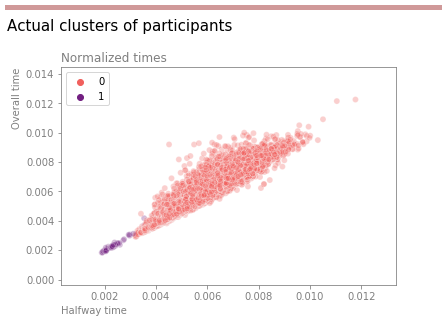

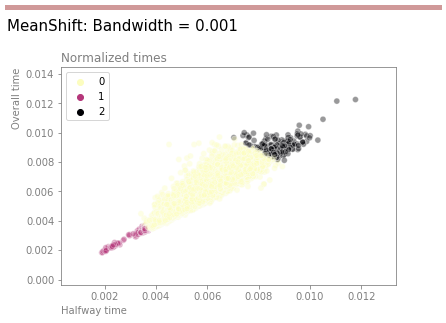

actual            0   1
ms2_bw_0.001           
0             31069   5
1               163  48
2               364   0 



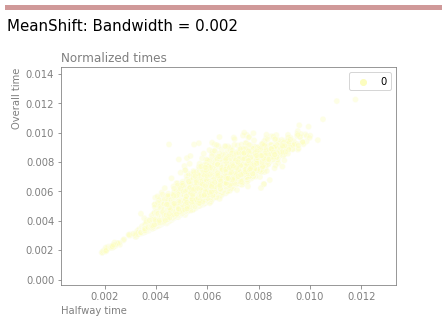

actual            0   1
ms2_bw_0.002           
0             31596  53 



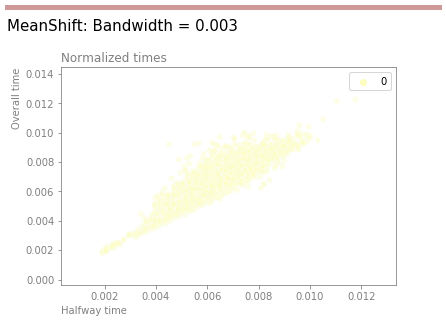

actual            0   1
ms2_bw_0.003           
0             31596  53 



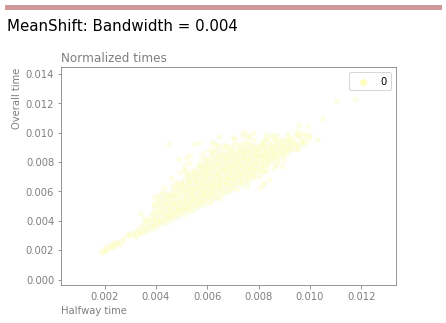

actual            0   1
ms2_bw_0.004           
0             31596  53 



In [23]:
## Using all numeric variables

results3 = pd.DataFrame()
results3['actual'] = bib

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
g = sns.scatterplot(half_off_norm[:, 0], half_off_norm[:, 1], hue=bib, 
                    alpha=.3, palette='magma_r')
ax.set_xlabel('Halfway time', color='gray', ha='left', x=0)
ax.set_ylabel('Overall time', color='gray', ha='right', y=1)
ax.set_title('Normalized times', color='gray', ha='left', x=0)
plt.suptitle('Actual clusters of participants', ha='left', x=0,
             y=1.05, fontsize=15)
line = lines.Line2D([0, 1], [1.09, 1.09], color='darkred', lw=5, alpha=.4,
                   transform=fig.transFigure)
line.set_clip_on(False)
ax.add_line(line)
plt.show()



for bw in np.arange(0.001, 0.005, 0.001):
    bib_model = MeanShift(bandwidth = bw, bin_seeding=True).fit(half_off_norm)
    bib_pred = bib_model.predict(half_off_norm)
    results3['ms2_bw_{}'.format(bw)] = bib_pred
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    g = sns.scatterplot(half_off_norm[:, 0], half_off_norm[:, 1],
                        hue=np.array(results3['ms2_bw_{}'.format(bw)]),
                        alpha=.4, palette='magma_r')
    ax.set_xlabel('Halfway time', color='gray', ha='left', x=0)
    ax.set_ylabel('Overall time', color='gray', ha='right', y=1)
    ax.set_title('Normalized times', color='gray', ha='left', x=0)
    fig.suptitle('MeanShift: Bandwidth = {}'.format(bw), ha='left', x=0, y=1.05,
               fontsize=15)
    line = lines.Line2D([0, 1], [1.09, 1.09], color='darkred', lw=5, 
                        alpha=.4, transform=fig.transFigure)
    line.set_clip_on(False)
    ax.add_line(line)
    plt.show()
    print(pd.crosstab(results3['ms2_bw_{}'.format(bw)], results3['actual']), '\n')

MeanShift can find clusters at very low bandwidth. Here it found three, one of which corresponds reasonably well to the wheelchair competitors, though contains a lot of other points too.

Spectral Clustering and Affinity Propagation took too much time.